# calculates the seasonal anomalies and the seasonal tercile categories from the gridded GCM

In [1]:
# Paramaters 
provider = 'IRI'
stage_in = 'processed'
period = 'hindcasts'
GCM = 'NASA_GEOSS2S'
var_name = 'PRECIP'
step = 3
remove_tmp = True

In [2]:
# gcms = ['NCEP_CFSv2','CanCM4i','CanSIPSv2', 'GEM_NEMO', 'NASA_GEOSS2S']

In [3]:
%matplotlib inline 

In [4]:
from matplotlib import pyplot as plt

In [5]:
import sys

In [6]:
sys.path.append('../../utils')

### set the root directory for loading the GCM outputs files 

In [7]:
from set_root_dir import set_root_dir

In [8]:
dpath = set_root_dir(root='gdata')

In [9]:
print(dpath)

/media/nicolasf/GDATA/END19101/Working/data


In [10]:
import os
import pathlib
from subprocess import call
import shutil

In [11]:
import salem 
import geopandas as gpd 

In [12]:
import numpy as np
import pandas as pd 

In [13]:
import xarray as xr

In [14]:
from cartopy import crs as ccrs

In [15]:
from datetime import datetime, timedelta

In [16]:
import calendar

In [17]:
import dateutil

### function to calculate the anomalies with respect to the 1981 - 2010 climatology 

In [18]:
def demean(x): 
    return x - x.loc['1981':'2010',].mean()

In [19]:
var_name

'PRECIP'

In [20]:
GCM

'NASA_GEOSS2S'

### set the home directory 

In [21]:
HOME = pathlib.Path.home() 

### set the working directory 

In [22]:
CWD = pathlib.Path.cwd()

#### input path for the GCM outputs 

In [23]:
ipath = dpath / 'GCMs' / stage_in / period / provider / GCM / var_name

In [24]:
ipath

PosixPath('/media/nicolasf/GDATA/END19101/Working/data/GCMs/processed/hindcasts/IRI/NASA_GEOSS2S/PRECIP')

In [25]:
lfiles_gcm = list(ipath.glob(f"{GCM}_{var_name}_seasonal_anomalies_????_??.nc")) 

In [26]:
lfiles_gcm.sort()

In [27]:
lfiles_gcm[0]

PosixPath('/media/nicolasf/GDATA/END19101/Working/data/GCMs/processed/hindcasts/IRI/NASA_GEOSS2S/PRECIP/NASA_GEOSS2S_PRECIP_seasonal_anomalies_1981_02.nc')

In [28]:
lfiles_gcm[-1]

PosixPath('/media/nicolasf/GDATA/END19101/Working/data/GCMs/processed/hindcasts/IRI/NASA_GEOSS2S/PRECIP/NASA_GEOSS2S_PRECIP_seasonal_anomalies_2016_12.nc')

In [29]:
ncks = "/home/nicolasf/anaconda3/envs/NCO/bin/ncks"

In [30]:
tmp_path = pathlib.Path.home() / 'data' / 'tmp'

In [31]:
if not tmp_path.exists(): 
    tmp_path.mkdir(parents=True)

### read files one by one (with SALEM), calculates the ensemble mean, select the step (3) extract the domain

In [32]:
for fname in lfiles_gcm: 
    cmd = f"{ncks} -d lat,-50.,-20. -d lon,100.,180. -d step,{step}.,{step}. {str(fname)} {str(tmp_path / fname.name)}"
    r = call(cmd, shell=True)
    print(f"processed {fname.name}, ret code {r}")

processed NASA_GEOSS2S_PRECIP_seasonal_anomalies_1981_02.nc, ret code 0
processed NASA_GEOSS2S_PRECIP_seasonal_anomalies_1981_03.nc, ret code 0
processed NASA_GEOSS2S_PRECIP_seasonal_anomalies_1981_04.nc, ret code 0
processed NASA_GEOSS2S_PRECIP_seasonal_anomalies_1981_05.nc, ret code 0
processed NASA_GEOSS2S_PRECIP_seasonal_anomalies_1981_06.nc, ret code 0
processed NASA_GEOSS2S_PRECIP_seasonal_anomalies_1981_07.nc, ret code 0
processed NASA_GEOSS2S_PRECIP_seasonal_anomalies_1981_08.nc, ret code 0
processed NASA_GEOSS2S_PRECIP_seasonal_anomalies_1981_09.nc, ret code 0
processed NASA_GEOSS2S_PRECIP_seasonal_anomalies_1981_10.nc, ret code 0
processed NASA_GEOSS2S_PRECIP_seasonal_anomalies_1981_11.nc, ret code 0
processed NASA_GEOSS2S_PRECIP_seasonal_anomalies_1981_12.nc, ret code 0
processed NASA_GEOSS2S_PRECIP_seasonal_anomalies_1982_01.nc, ret code 0
processed NASA_GEOSS2S_PRECIP_seasonal_anomalies_1982_02.nc, ret code 0
processed NASA_GEOSS2S_PRECIP_seasonal_anomalies_1982_03.nc, ret

In [33]:
lfiles_tmp = list(tmp_path.glob(f"{GCM}_{var_name}_seasonal_anomalies_????_??.nc")) 

In [34]:
lfiles_tmp.sort()

In [35]:
lfiles_tmp[0]

PosixPath('/home/nicolasf/data/tmp/NASA_GEOSS2S_PRECIP_seasonal_anomalies_1981_02.nc')

In [36]:
lfiles_tmp[-1]

PosixPath('/home/nicolasf/data/tmp/NASA_GEOSS2S_PRECIP_seasonal_anomalies_2016_12.nc')

In [37]:
dset_l = []
time_l = []
for fname in lfiles_tmp: 
    dset = salem.open_xr_dataset(fname)
    # here make sure that we drop potentially conflicting variables and coordinates
    if 'surface' in dset.variables: 
        dset = dset.drop('surface') 
    if 'valid_time' in dset.coords: 
        dset = dset.drop('valid_time')
    dset = dset.mean('member') 
    dset = dset.sel(step=step)
    time = pd.to_datetime(dset.time.data) + dateutil.relativedelta.relativedelta(month=step + 1)
    time_l.append(time)
    dset_l.append(dset)

In [38]:
dset = xr.concat(dset_l, dim='time')

In [39]:
dset

<xarray.Dataset>
Dimensions:  (lat: 31, lon: 81, time: 431)
Coordinates:
    step     int64 3
  * lon      (lon) float32 100.0 101.0 102.0 103.0 ... 177.0 178.0 179.0 180.0
  * lat      (lat) float32 -50.0 -49.0 -48.0 -47.0 ... -23.0 -22.0 -21.0 -20.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 1981-02-01 1981-03-01 ... 2016-12-01
Data variables:
    precip   (time, lat, lon) float32 0.14178991 0.023297489 ... -0.09685099

### only needed if the forecast period is mistakenly included in the hindcast folder 

In [40]:
if pd.to_datetime(dset.time[-1].data).year > 2016: 
    dset = dset.sel(time=slice(None, '2016')) # only needed if 

### shift the time index, to reflect the actual forecast valid time 

In [41]:
dset['time'] = dset.time.to_index().shift(step + 1, freq='M')

In [42]:
dset.time[0].data

array('1981-05-31T00:00:00.000000000', dtype='datetime64[ns]')

In [43]:
dset.time[-1].data

array('2017-03-31T00:00:00.000000000', dtype='datetime64[ns]')

In [44]:
dset

<xarray.Dataset>
Dimensions:  (lat: 31, lon: 81, time: 431)
Coordinates:
    step     int64 3
  * lon      (lon) float32 100.0 101.0 102.0 103.0 ... 177.0 178.0 179.0 180.0
  * lat      (lat) float32 -50.0 -49.0 -48.0 -47.0 ... -23.0 -22.0 -21.0 -20.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 1981-05-31 1981-06-30 ... 2017-03-31
Data variables:
    precip   (time, lat, lon) float32 0.14178991 0.023297489 ... -0.09685099

### reads the NZ 6 regions shapefiles 

In [45]:
nz_regions = gpd.read_file(set_root_dir(root='local') / 'shapefiles' / 'NZ_regions' / 'NZ_6_regions' / 'NZ_regions_corrected.shp') 

In [46]:
nz_regions

,OBJECTID,Id,gridcode,Shape_Leng,Shape_Area,Location,geometry
0,1,1,1,85.215338,5.032753,NNI,"MULTIPOLYGON (((174.70530 -38.17377, 174.70545..."
1,2,2,2,12.336015,2.994028,WNI,"MULTIPOLYGON (((175.13516 -41.37745, 175.13507..."
2,3,3,3,14.235493,3.775388,ENI,"MULTIPOLYGON (((175.85595 -41.35970, 175.85595..."
3,4,4,4,34.656463,3.066280,NSI,"MULTIPOLYGON (((171.32620 -42.12355, 171.32602..."
4,5,5,6,20.191504,4.827228,ESI,"MULTIPOLYGON (((170.21675 -46.05955, 170.21609..."
5,6,6,5,42.941379,9.057410,WSI,"MULTIPOLYGON (((169.20749 -46.66371, 169.20742..."


In [47]:
nz_regions = nz_regions.to_crs(epsg=4326)

In [48]:
nz_regions.crs

{'init': 'epsg:4326', 'no_defs': True}

In [49]:
opath_root = HOME / 'research' / 'Smart_Ideas' / 'outputs' / 'targets' / 'GCMs' / 'NZ_6_regions' / GCM / var_name

In [50]:
if not opath_root.exists(): 
    opath_root.mkdir(parents=True)

### defines the number of quantiles we want 

In [51]:
num_quantiles = 3

In [52]:
quant_values = np.linspace(0, 1, num_quantiles + 1, endpoint=True)

In [53]:
quant_values = quant_values[1:-1]

In [54]:
quant_values

array([0.33333333, 0.66666667])

In [55]:
col_labs = [f"Q{int(x)}" for x in (quant_values*100)]

In [56]:
col_labs

['Q33', 'Q66']

### plots the regions for the GCMs grid 

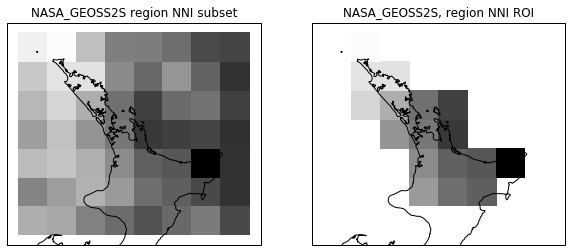

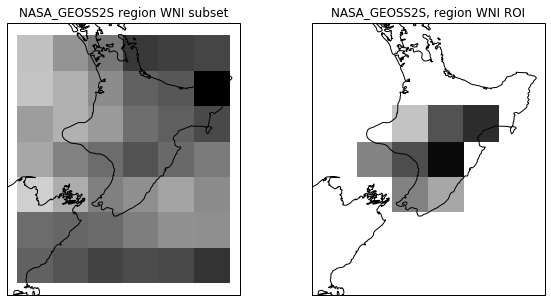

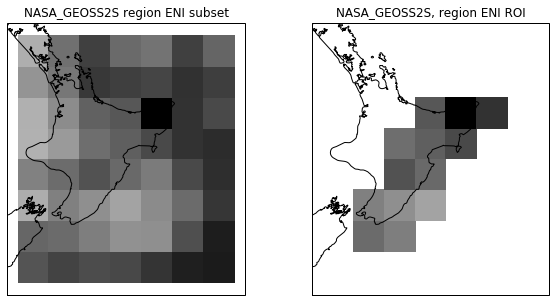

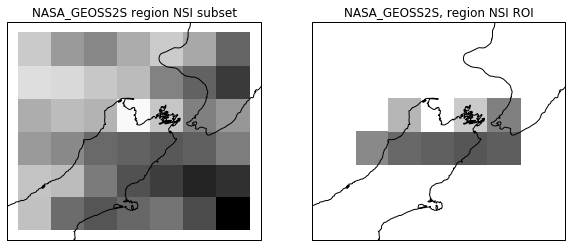

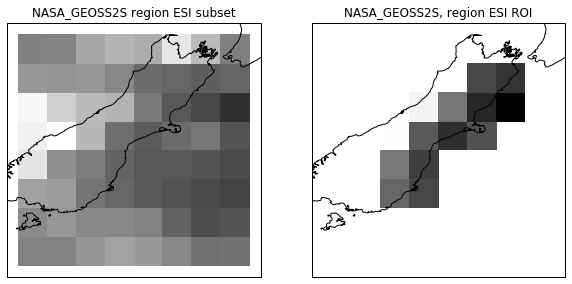

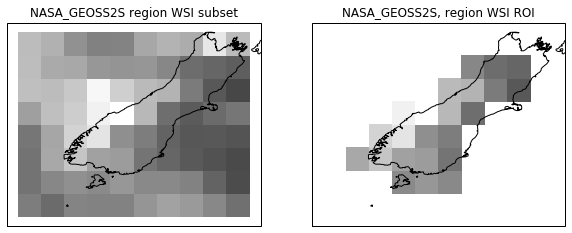

In [57]:
for region_name in nz_regions.Location.values:
    
    shape = nz_regions.query(f"Location == '{region_name}'")
    
    f, axes = plt.subplots(figsize=(10, 5), ncols=2, subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)}) 

    region = dset.salem.subset(shape=shape, margin=2)

    region[var_name.lower()][0,:,:].plot(ax=axes[0], transform=ccrs.PlateCarree(), add_colorbar=False, cmap='binary')

    axes[0].coastlines(resolution='10m')

    axes[0].set_title(f'{GCM} region {region_name} subset')

    if ((region.dims['lat'] > 1) & (region.dims['lon'] > 1)):

        region = region.salem.roi(shape=shape, all_touched=True)

        region[var_name.lower()][0,:,:].plot(ax=axes[1], transform=ccrs.PlateCarree(), add_colorbar=False, cmap='binary')

        axes[1].coastlines(resolution='10m')

        axes[1].set_title(f'{GCM}, region {region_name} ROI')

    f.savefig(CWD.parents[2] / 'figures' / f'subset_and_ROI_map_{GCM}_{region_name}.png', dpi=200, bbox_inches='tight')

### Now loops over the regions names, extract, calculate regional index and save to file 

In [58]:
quantiles_dict = {}

for region_name in nz_regions.Location.values: 
    
    shape = nz_regions.query(f"Location == '{region_name}'")
    
    region = dset.salem.subset(shape=shape, margin=1)
    
    if ((region.dims['lat'] > 1) & (region.dims['lon'] > 1)):

        region = region.salem.roi(shape=shape, all_touched=True)
        
    else: 
        
        print(f"Warning: region {region_name} boundaries do not allow the ROI to be calculated")
    
    # if there's useless dimension 'Z', drop from the dataset 
    
    if 'Z' in region.dims: 
        region = region.sel(Z = region.Z.data[0])
        region = region.drop('Z')
    
    ts = region.mean(dim=['lat','lon'])
    
    ts_df = ts[var_name.lower()].to_dataframe()
            
    ts_series = ts_df.loc[:,var_name.lower()]
    
    ts_series_cat = []
    
    quantiles_list = []
    
    for month in range(1, 13):
        
        ts_series_m = ts_series[ts_series.index.month == month]
        
        clim = ts_series_m.loc['1993':'2016']
        
        quantiles = [clim.quantile(q=q) for q in quant_values.tolist()]
        
        quantiles_list.append(quantiles.copy())
        
        quantiles.insert(0, -np.inf)
        
        quantiles.append(np.inf)
        
        ts_series_m_cats = pd.cut(ts_series_m, quantiles, labels=list(range(1, num_quantiles + 1)))
        
        ts_series_cat.append(ts_series_m_cats)
        
        del(quantiles)
     
    quantiles_dict[region_name]  = np.array(quantiles_list)
    
    ts_series_cat = pd.concat(ts_series_cat, axis=0)
    
    ts_series_cat = ts_series_cat.sort_index()
    
    ts_df.loc[:,f'cat_{num_quantiles}'] = ts_series_cat
    
    ts_df.loc[:,'anomalies'] = ts_df.loc[:,var_name.lower()]
    
    ts_df = ts_df.loc[:,['month',f'cat_{num_quantiles}','anomalies']]
    
    opath = opath_root / region_name 
    
    if not opath.exists(): 
        opath.mkdir(parents=True)
        
    ts_df.to_csv(opath / f'TS_NZ_region_{region_name}_{GCM}_{var_name}_{num_quantiles}_quantiles_anoms.csv')
    
    #descriptive statistics per quantile category 
    
    ts_df.groupby(ts_df.loc[:,f'cat_{num_quantiles}']).describe().to_csv(opath / f'descriptive_stats_{region_name}_{GCM}_{var_name}_{num_quantiles}.csv')
    
    print(f"region {region_name} processed for variable {var_name} in {GCM}")
    

region NNI processed for variable PRECIP in NASA_GEOSS2S
region WNI processed for variable PRECIP in NASA_GEOSS2S
region ENI processed for variable PRECIP in NASA_GEOSS2S
region NSI processed for variable PRECIP in NASA_GEOSS2S
region ESI processed for variable PRECIP in NASA_GEOSS2S
region WSI processed for variable PRECIP in NASA_GEOSS2S


In [59]:
opath

PosixPath('/home/nicolasf/research/Smart_Ideas/outputs/targets/GCMs/NZ_6_regions/NASA_GEOSS2S/PRECIP/WSI')

### saves the climatological terciles calculated from the VCSN regional aggregates

In [60]:
quantiles_list = []
for region_name in nz_regions.Location.values: 
    df = pd.DataFrame(quantiles_dict[region_name])
    df.index = range(1, 13)
    df.index.name = 'season'
    df.columns = pd.MultiIndex.from_product([[region_name],col_labs])
    quantiles_list.append(df)

In [61]:
quantiles_df = pd.concat(quantiles_list, axis=1)

In [62]:
opath

PosixPath('/home/nicolasf/research/Smart_Ideas/outputs/targets/GCMs/NZ_6_regions/NASA_GEOSS2S/PRECIP/WSI')

In [63]:
quantiles_df.to_csv(opath.parent / f'Climatological_quantiles_{num_quantiles}_cat_{var_name}.csv')

In [64]:
quantiles_df

NNI                 WNI                 ENI                 NSI  \
             Q33       Q66       Q33       Q66       Q33       Q66       Q33   
season                                                                         
1      -0.332150  0.313672 -0.300115  0.086857 -0.335317  0.243085 -0.267336   
2      -0.286726  0.263928 -0.106194  0.181469 -0.233902  0.181436 -0.238034   
3      -0.399160  0.222830 -0.209376  0.138363 -0.328138  0.302027 -0.384007   
4      -0.355622  0.166019 -0.364847  0.139228 -0.366686  0.143561 -0.239802   
5      -0.144327  0.078251 -0.093468  0.066902 -0.192534  0.093516 -0.260475   
6      -0.261612  0.168958 -0.175973  0.092731 -0.218595  0.146081 -0.106111   
7      -0.175431  0.073111 -0.116100  0.087702 -0.220086  0.071470 -0.147610   
8      -0.180473  0.051848 -0.091003  0.016043 -0.130368  0.100801 -0.149031   
9      -0.131592  0.068624 -0.139051  0.129827 -0.099715  0.067950 -0.106835   
10     -0.201774  0.190229 -0.096955  0.159411 -0.200248  0.191624 -0.282946   
11     -0.074891  0.104619 -0.155498  0.147301 -0.093346  0.076660 -0.122904   
12     -0.104170  0.080485 -0.143591  0.143520 -0.112639  0.166503 -0.142956   

                       ESI                 WSI            
             Q66       Q33       Q66       Q33       Q66  
season                                                    
1       0.282418 -0.264167  0.155774 -0.303286  0.096172  
2       0.232701 -0.121321  0.077767 -0.202580  0.221782  
3       0.152902 -0.269747  0.108559 -0.220376  0.065551  
4       0.197164 -0.178641  0.016915 -0.265264  0.292326  
5       0.249403 -0.166994  0.084285 -0.195093  0.154921  
6       0.235883 -0.122868  0.150695 -0.215069  0.221289  
7       0.185750 -0.133684  0.152808 -0.271402  0.056785  
8       0.093369 -0.106882  0.087490 -0.275839  0.135110  
9       0.219985 -0.118286  0.093154 -0.094502  0.192720  
10      0.128945 -0.131361  0.107965 -0.150096  0.257004  
11      0.154276 -0.060263  0.087000 -0.072876  0.152351  
12      0.205013 -0.097060  0.122410 -0.178374  0.157006

### plots the anomalies and the categories 

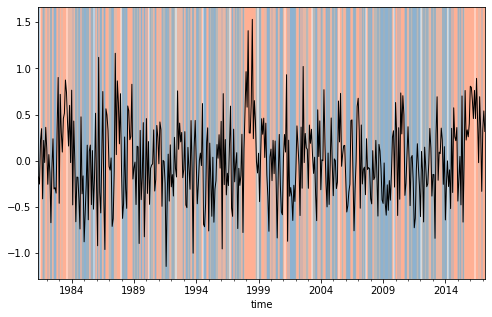

In [65]:
f, ax = plt.subplots(figsize=(8,5))
ts_df.anomalies.plot(lw=1, color='k', zorder=0)
cats = pd.to_numeric(ts_df.cat_3)
[ax.axvline(x, color='steelblue', alpha=0.5,lw=1.5, zorder=-10) for x in cats.loc[(cats == 1),].index];
[ax.axvline(x, color='k', alpha=0.2, lw=1.5, zorder=-10) for x in cats.loc[(cats == 2),].index];
[ax.axvline(x, color='coral', alpha=0.5,lw=1.5, zorder=-10) for x in cats.loc[(cats == 3),].index];
f.savefig('/home/nicolasf/Desktop/essai.png', dpi=200, bbox_inches='tight')

In [66]:
tmp_path

PosixPath('/home/nicolasf/data/tmp')

In [67]:
if remove_tmp: 
    shutil.rmtree(tmp_path)

In [68]:
print(f"\n\n\nPROCESSING FINISHED FOR {GCM} -> {var_name}")




PROCESSING FINISHED FOR NASA_GEOSS2S -> PRECIP
